In [3]:
import numpy as np # работа с многомерными массивами
import matplotlib.pyplot as plt # создание графиков 
import sklearn.linear_model as sklm # работа с линейными моделями зависимостей
import sklearn.metrics as metrics # работа с метриками для вычисления псевдорасстояний между векторами

In [4]:
def generate_dataset(N=20, noise_scale=8.0, outliers=True):
    X = np.linspace(-1., 1., N)
    Y0 = 3*X+1
    noise = np.random.random(size=len(X))
    noise = 2*noise-1
    Y = Y0 + 0.5 * noise
    
    Y_outl = Y.copy()
    if outliers:
        i1, i2, i3 = int(N/9), int(8*N/9), int(N/2)
        Y_outl[i1] += noise_scale
        Y_outl[i2] -= noise_scale/2.0
        Y_outl[i3] += noise_scale
    
    return X, Y0, Y, Y_outl


In [5]:
X, Y0, Y, Y_outl = generate_dataset()
Xs = X.reshape(-1,1)

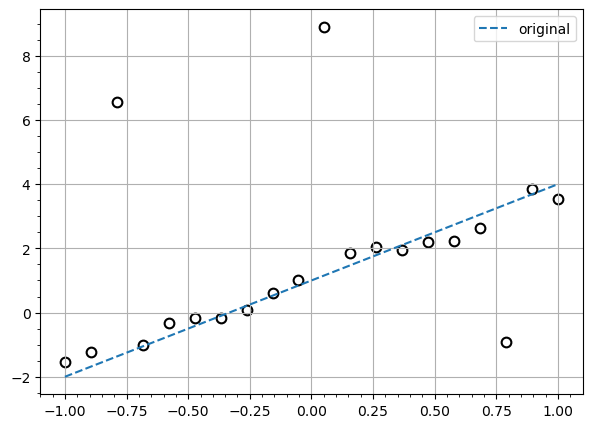

In [6]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y_outl, s=49, c='w', edgecolor='k', linewidth=1.5)
plt.plot(X, Y0, linestyle='--', label='original')
plt.legend()
plt.grid(1)
plt.minorticks_on()
plt.show()

In [7]:
regr_hub = sklm.HuberRegressor()
regr_hub.fit(Xs, Y_outl)

HuberRegressor()

In [8]:
regr_sqr = sklm.LinearRegression()
regr_sqr.fit(Xs, Y_outl)

LinearRegression()

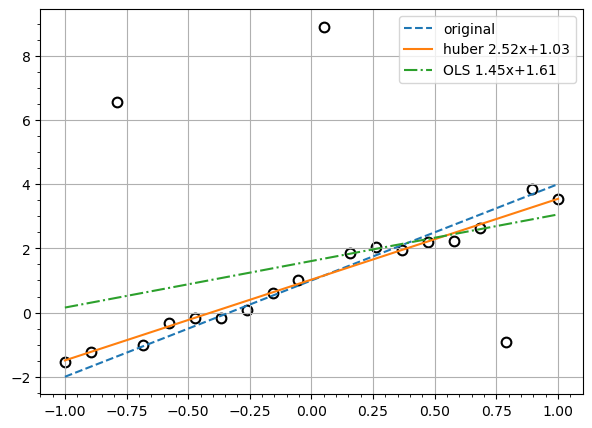

In [9]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y_outl, s=49, c='w', edgecolor='k', linewidth=1.5)
plt.plot(X, Y0, linestyle='--', label='original')
label_huber = "huber %.2fx+%.2f" % (regr_hub.coef_[0], regr_hub.intercept_)
label_OLS = "OLS %.2fx+%.2f" % (regr_sqr.coef_[0], regr_sqr.intercept_)
plt.plot(X, regr_hub.predict(Xs), linestyle='-', label=label_huber)
plt.plot(X, regr_sqr.predict(Xs), linestyle='-.', label=label_OLS)
plt.legend()
plt.grid(1)
plt.minorticks_on()
plt.show()

In [10]:
def generate_dataset2(N=20, noise_scale=4.0):
    X = np.linspace(-1., 1., N)
    Y0 = 3*X+1
    noise = np.random.random(size=len(X))
    noise = 2*noise-1
    Y = Y0 + 0.5 * noise
    
    Y_outl = Y.copy()
    i1, i2 = int(N/10), int(9*N/10)
    i3, i4 = int(2*N/10), int(8*N/10)
    i5, i6 = 0, -1
    Y_outl[i1] += noise_scale
    Y_outl[i2] -= noise_scale
    Y_outl[i3] += noise_scale
    Y_outl[i4] -= noise_scale
    Y_outl[i5] += noise_scale
    Y_outl[i6] -= noise_scale
    
    return X, Y0, Y, Y_outl

In [21]:
X1, Y10, Y1, Y1_outl = generate_dataset2(noise_scale=2.0)
X1s = X1.reshape(-1,1)

In [22]:
regr_hub2 = sklm.HuberRegressor()
regr_hub2.fit(X1s, Y1_outl)
regr_ols2 = sklm.LinearRegression()
regr_ols2.fit(X1s, Y1_outl)

LinearRegression()

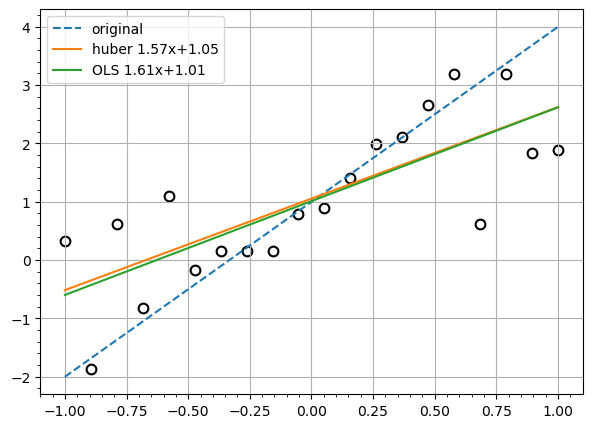

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(X1, Y1_outl, s=49, c='w', edgecolor='k', linewidth=1.5)
plt.plot(X1, Y10, linestyle='--', label='original')
label_huber2 = "huber %.2fx+%.2f" % (regr_hub2.coef_[0], regr_hub2.intercept_)
label_OLS2 = "OLS %.2fx+%.2f" % (regr_ols2.coef_[0], regr_ols2.intercept_)
plt.plot(X1, regr_hub2.predict(X1s), linestyle='-', label=label_huber2)
plt.plot(X1, regr_ols2.predict(X1s), linestyle='-', label=label_OLS2)
plt.legend(loc='best')
plt.grid(1)
plt.minorticks_on()
plt.show()

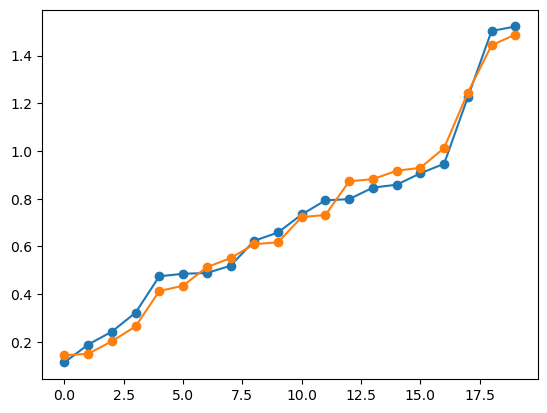

In [24]:
plt.plot(sorted(np.abs(regr_hub2.predict(X1s)-Y1_outl)), label='huber', marker='o')
plt.plot(sorted(np.abs(regr_ols2.predict(X1s)-Y1_outl)), label='ols', marker='o')
plt.show()

$$
Q(w) = \sum_{k=1}^N \rho(r_k(w)),\qquad r_k(w)=f(x_k;w)-y_k
$$

$$
\nabla Q(w) = \sum_{k=1}^N \frac{\rho^\prime(r_k(w))}{r_k(w)}r_k(w)\nabla r_k(w)
$$

$\varphi(r) = \rho^\prime(r)/r$

$$
\nabla Q(w) = \sum_{k=1}^N \varphi(r_k(w))\frac{1}{2} \nabla r_k(w)^2
$$


$$
w^{t+1} = \arg\min_w \sum_{k=1}^N v_k^t r_k(w)^2, \qquad v_k^t = \varphi(r_k(w^t))
$$

In [26]:
class IRLS:
    #
    def __init__(self, phi, tol=1.0e-8, n_iter=100):
        self.phi = phi
        self.tol = tol
        self.n_iter = n_iter
    #
    def fit(self, X, Y):
        N = len(X)
        self.weights = np.ones(N, 'd') # вектор весов
        for K in range(self.n_iter):
            self.regr = sklm.LinearRegression()
            self.regr.fit(X, Y, sample_weight=self.weights)

            res = np.abs(self.regr.predict(X) - Y)
            self.weights = self.phi(res)

            if K > 0:
                d_coef_ = np.abs(prev_coef_ - self.regr.coef_)
                d_intercept_ = np.abs(prev_intercept_ - self.regr.intercept_)
                if np.max(d_coef_) < self.tol and d_intercept_ < self.tol:
                    break
                    
            prev_coef_ = self.regr.coef_
            prev_intercept_ = self.regr.intercept_
                    
        self.K = K + 1
        
    def predict(self, X):
        return self.regr.predict(X)

$$
h(r) = \cases{
r^2/2 & если $r\leq C$\\
Cr - C^2/2 & если $r>C$\\
}
$$

$$
h^\prime(r) = \cases{
r & если $r\leq C$\\
C & если $r>C$\\
}
$$

$$
\varphi(r) = \cases{
1 & если $r\leq C$\\
C/r & если $r>C$\\
}
$$

$$
h_C(r) = \sqrt{C^2+r^2} - C
$$

$$
h_C^\prime(r) = \frac {r} {\sqrt{C^2+r^2}}
$$

$$
\varphi(r) = \frac {1} {\sqrt{C^2+r^2}}
$$

In [27]:
def phi_huber(r, C=1.5):
    Y = np.ones(r.shape, 'd')
    np.putmask(Y, r > C, C / r)
    return Y

def phi_sqrt(r, C=0.1):
    return 1 / np.sqrt(C**2 + r**2)

In [28]:
irls = IRLS(phi_huber)
irls.fit(X1s, Y1_outl)

In [32]:
irls2 = IRLS(phi_sqrt, n_iter=200)
irls2.fit(X1s, Y1_outl)

In [33]:
print(irls.K, irls.regr.coef_, irls.regr.intercept_)

2 [1.60908785] 1.0114897299351153


In [34]:
print(irls2.K, irls2.regr.coef_, irls2.regr.intercept_)

141 [2.01651503] 0.9136356378096601


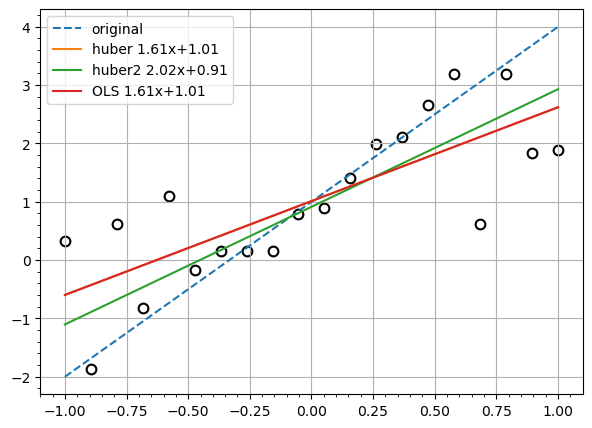

In [35]:
plt.figure(figsize=(7,5))
plt.scatter(X1, Y1_outl, s=49, c='w', edgecolor='k', linewidth=1.5)
plt.plot(X1, Y10, linestyle='--', label='original')
label_irls = "huber %.2fx+%.2f" % (irls.regr.coef_[0], irls.regr.intercept_)
label_irls2 = "huber2 %.2fx+%.2f" % (irls2.regr.coef_[0], irls2.regr.intercept_)
label_OLS2 = "OLS %.2fx+%.2f" % (regr_ols2.coef_[0], regr_ols2.intercept_)
plt.plot(X1, irls.predict(X1s), linestyle='-', label=label_irls)
plt.plot(X1, irls2.predict(X1s), linestyle='-', label=label_irls2)
plt.plot(X1, regr_ols2.predict(X1s), linestyle='-', label=label_OLS2)
plt.legend(loc='best')
plt.grid(1)
plt.minorticks_on()
plt.show()

In [36]:
import pandas as pd

In [38]:
df = pd.read_csv("data/starsCYG.csv", sep=',')
df

,id,log.Te,log.light
0,1,4.37,5.23
1,2,4.56,5.74
2,3,4.26,4.93
3,4,4.56,5.74
4,5,4.30,5.19
5,6,4.46,5.46
6,7,3.84,4.65
7,8,4.57,5.27
8,9,4.26,5.57
9,10,4.37,5.12


In [41]:
X = df['log.Te'].values
Y = df['log.light'].values
Xs = X.reshape(-1,1)

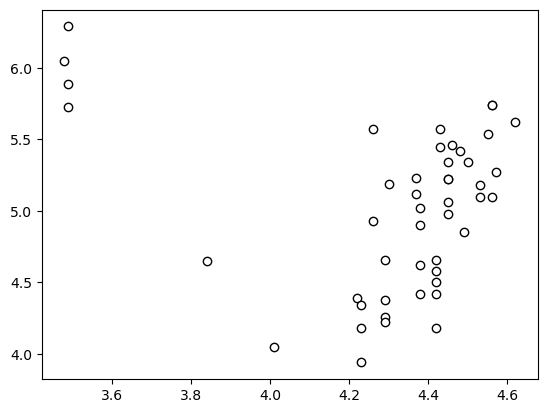

In [40]:
plt.scatter(X, Y, c='w', edgecolors='k')
plt.show()

In [43]:
irls_hub = IRLS(phi_huber)
irls_hub.fit(Xs, Y)

In [44]:
irls_sqrt = IRLS(phi_sqrt)
irls_sqrt.fit(Xs, Y)

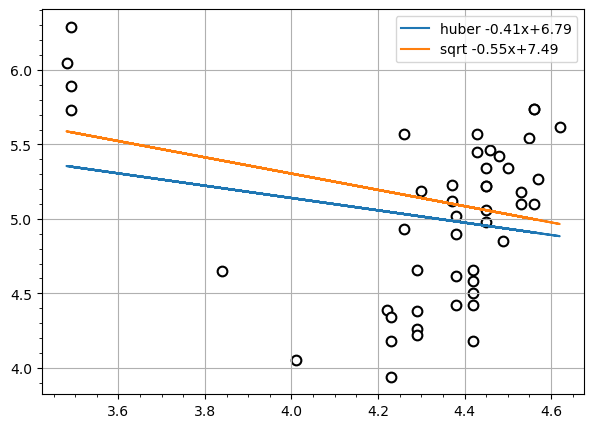

In [47]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y, s=49, c='w', edgecolor='k', linewidth=1.5)
label_irls = "huber %.2fx+%.2f" % (irls_hub.regr.coef_[0], irls_hub.regr.intercept_)
label_sqrt = "sqrt %.2fx+%.2f" % (irls_sqrt.regr.coef_[0], irls_sqrt.regr.intercept_)
plt.plot(X, irls_hub.predict(Xs), linestyle='-', label=label_irls)
plt.plot(X, irls_sqrt.predict(Xs), linestyle='-', label=label_sqrt)
plt.legend(loc='best')
plt.grid(1)
plt.minorticks_on()
plt.show()